In [ ]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from PIL import Image
from IPython.display import Image, display
import os

from sklearn.metrics import confusion_matrix
from sklearn.datasets import load_files
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_hub as hub
from keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.applications import  MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, GlobalAveragePooling2D, BatchNormalization, Dropout, MaxPool2D, MaxPooling2D
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
# load the backend
from keras import backend as K

# prevent Tensorflow memory leakage
K.clear_session()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path_data = '/content/drive/MyDrive/ORAL_CANCER_DATASET/oral/combined'
print(os.listdir(path_data))

['oscc', 'normal']


In [ ]:
from os.path import join

img_folders = [join(path_data, folder) for folder in os.listdir(path_data)]
list(img_folders)

['/content/drive/MyDrive/ORAL_CANCER_DATASET/oral/combined/oscc',
 '/content/drive/MyDrive/ORAL_CANCER_DATASET/oral/combined/normal']

In [ ]:
data_dir = '/content/drive/MyDrive/ORAL_CANCER_DATASET/oral/combined'

data = load_files(data_dir, random_state=28, shuffle=True)
X = np.array(data['filenames'])    # files location of each image
y = np.array(data['target'])       # target label of each image
labels = np.array(data['target_names'])
# remove eventual .pyc or .py files
pyc_file = (np.where(file==X) for file in X if file.endswith(('.pyc','.py')))
for pos in pyc_file:
    X = np.delete(X, pos)
    y = np.delete(y, pos)
    
print(f'Data files - {X}')
print(f'Target labels - {y}')   # numbers are corresponding to class label, 
                               # we have to change them to a vector of 5 elements
print(f'Name labels - {labels}')
print(f'Number of training files : {X.shape[0]}')

Data files - ['/content/drive/MyDrive/ORAL_CANCER_DATASET/oral/combined/normal/Normal_400x_122.jpg'
 '/content/drive/MyDrive/ORAL_CANCER_DATASET/oral/combined/normal/Normal_400x_102.jpg'
 '/content/drive/MyDrive/ORAL_CANCER_DATASET/oral/combined/oscc/OSCC_100x_85.jpg'
 ...
 '/content/drive/MyDrive/ORAL_CANCER_DATASET/oral/combined/normal/Normal_400x_145.jpg'
 '/content/drive/MyDrive/ORAL_CANCER_DATASET/oral/combined/normal/Normal_100x_89.jpg'
 '/content/drive/MyDrive/ORAL_CANCER_DATASET/oral/combined/oscc/OSCC_400x_359.jpg']
Target labels - [0 0 1 ... 0 0 1]
Name labels - ['normal' 'oscc']
Number of training files : 1264


In [ ]:
df = pd.DataFrame({'result': y})
print(df.shape)
df.head()

(1264, 1)


,result
0,0
1,0
2,1
3,0
4,0


In [ ]:
# # associate names to species number
# df['test'] = df['result'].astype('category')
# df['result'].cat.categories = labels
# df.head()

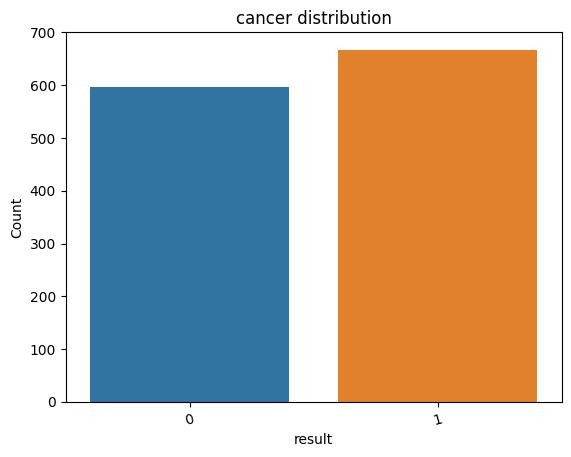

In [ ]:
fig, ax = plt.subplots()
ax = sns.countplot(x="result", data=df)
ax.set(ylabel='Count', title='cancer distribution')
ax.tick_params(axis='x', rotation=15)

In [ ]:
image_size = 224     

def read_and_prep_images(img_paths, img_height=image_size, img_width=image_size):
    imgs = [load_img(img_path, target_size=(img_height, img_width)) for img_path in img_paths]   # load image
    img_array = np.array([img_to_array(img) for img in imgs])   # image to array 
    return(img_array)

X = np.array(read_and_prep_images(X))
print(X.shape)  # (5192, 224, 224, 3) = (num_images, height_size, width_size, depth=RGB)

(1264, 224, 224, 3)


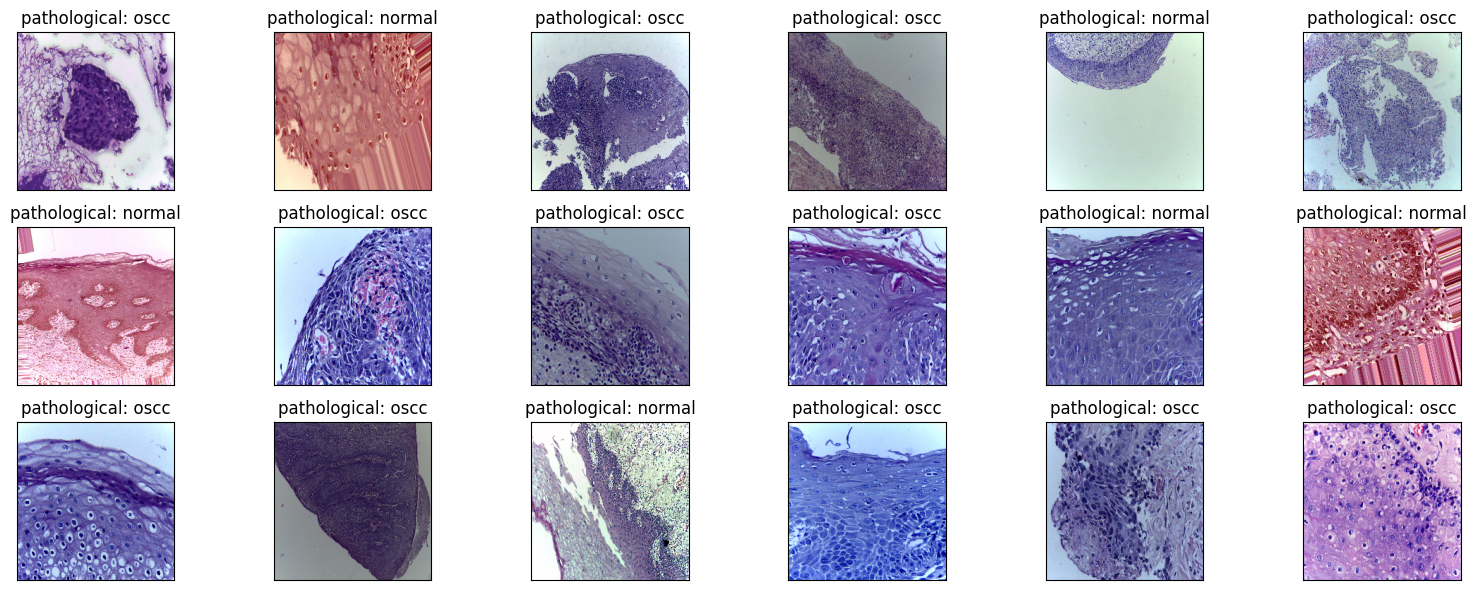

In [ ]:
N = 18  #pathological to display
fig, axes = plt.subplots(3, 6, figsize=(16,6))
for ax, j in zip(axes.flat, np.random.randint(0, len(X), N)):    
    ax.imshow(X[j].astype(np.uint8))
    ax.set(title=f'pathological: {labels[y[j]]}', xticks=[], yticks=[])
fig.tight_layout()

In [ ]:
num_classes = len(np.unique(y))
print(f'Number of classes: {num_classes} --> {labels}')

Number of classes: 2 --> ['normal' 'oscc']


In [ ]:
y = to_categorical(y, num_classes)
print(y.shape)

(1264, 2)


In [ ]:
y[9]

array([0., 1.], dtype=float32)

In [ ]:
#train, validation and test from the train dataset
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, shuffle=True, 
                                                test_size=0.25, random_state=28)

Xval, Xtest, yval, ytest = train_test_split(Xtest, ytest, test_size=0.5,
                                            shuffle=True, random_state=28)
print(f'Train dataset: {Xtrain.shape[0]}')
print(f'Validation dataset: {Xval.shape[0]}')
print(f'Test dataset: {Xtest.shape[0]}')

Train dataset: 948
Validation dataset: 158
Test dataset: 158


In [ ]:
# release memory
del X

In [ ]:
del y

In [ ]:
img_shape = (image_size, image_size, 3)

print('Loading MobileNetV2 ...')
base_model = MobileNetV2(input_shape=img_shape,
                   include_top=False,
                   weights='imagenet')
print('MobileNetV2 loaded')

base_model.trainable = False

Loading MobileNetV2 ...
9406464/9406464 [==============================] - 2s 0us/step
MobileNetV2 loaded


In [ ]:
base_model.output_shape

(None, 7, 7, 1280)

In [ ]:
num_classes

2

In [ ]:
model = Sequential([base_model,
                    GlobalAveragePooling2D(), 
                    Dense(num_classes, activation='softmax')
                   ])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
# callbacks 
weight_path = '{}_best_weights.hdf5'.format('flower')
checkpointer = ModelCheckpoint(weight_path,
                               monitor='val_accuracy',
                               verbose=1, 
                               save_best_only=True,
                               mode='auto',
                               save_weights_only=True)
# set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.7, 
                                            min_lr=0.00001)
# early stop if not improvement of accuracy after 5 epochs
early = EarlyStopping(patience=6, 
                      verbose=1) 
    
callbacks = [checkpointer, learning_rate_reduction] #, early]

# Optimizer
opt = tf.keras.optimizers.legacy.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
# Compilation
model.compile(optimizer=opt, 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
from keras.applications.mobilenet import preprocess_input

In [ ]:
#augmentation

image_size = 224
batch_size = 32
path = '/content/drive/MyDrive/NewDataset/combined'

train_datagen = ImageDataGenerator(
        # rescale=1./255,           # rescale pixel values [0,255] to [0,1]
        preprocessing_function=preprocess_input,       
        horizontal_flip=True,     # random horizontal flip
        width_shift_range=0.2,    # random shift images horizontally (fraction of total width)
        height_shift_range=0.2,   # random shift images vertically (fraction of total height)
        zoom_range=0.2)           # random zoom image
        #rotation_range=20,       # random rotation
        #shear_range=0.2)         # shear transfo
        #validation_split=0.2)    # splitting train / test datasets

test_datagen = ImageDataGenerator(
        # rescale=1./255
        preprocessing_function=preprocess_input  )
        #validation_split=0.2)
train_gen = train_datagen.flow(
        Xtrain, ytrain, 
        batch_size=batch_size,
        shuffle=False)    
valid_gen = test_datagen.flow(
        Xval, yval,
        batch_size=batch_size,
        shuffle=False)   


In [ ]:
batch_size = 32
epochs_0 = 40
steps_per_epoch = len(train_gen.x) // train_gen.batch_size
validation_steps = len(valid_gen.x) // valid_gen.batch_size

history = model.fit(
    train_gen,
    steps_per_epoch=len(Xtrain) // batch_size,   # or batch_size=32
    epochs=epochs_0 ,
    validation_data=valid_gen,
    validation_steps=len(Xval) // batch_size,
    callbacks=callbacks)

Epoch 1/40
29/29 [==============================] - ETA: 0s - loss: 0.5890 - accuracy: 0.7085
Epoch 1: val_accuracy improved from -inf to 0.81250, saving model to flower_best_weights.hdf5
29/29 [==============================] - 23s 443ms/step - loss: 0.5890 - accuracy: 0.7085 - val_loss: 0.4505 - val_accuracy: 0.8125 - lr: 0.0010
Epoch 2/40
29/29 [==============================] - ETA: 0s - loss: 0.4541 - accuracy: 0.8046
Epoch 2: val_accuracy improved from 0.81250 to 0.86719, saving model to flower_best_weights.hdf5
29/29 [==============================] - 12s 413ms/step - loss: 0.4541 - accuracy: 0.8046 - val_loss: 0.3743 - val_accuracy: 0.8672 - lr: 0.0010
Epoch 3/40
29/29 [==============================] - ETA: 0s - loss: 0.4156 - accuracy: 0.8341
Epoch 3: val_accuracy did not improve from 0.86719
29/29 [==============================] - 12s 391ms/step - loss: 0.4156 - accuracy: 0.8341 - val_loss: 0.3625 - val_accuracy: 0.8594 - lr: 0.0010
Epoch 4/40
29/29 [=======================

In [ ]:
def plot_history(history, loss_max=5):
    """
    Check loss and accuracy evolution.
    """
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(14, 4))
    ax1.plot(acc, label='Training')
    ax1.plot(val_acc, label='Validation')
    ax1.legend(loc='lower right')
    ax1.set(ylabel='Accuracy', title='Training - Validation Accuracy', 
            ylim=([min(plt.ylim()),1]))

    ax2.plot(loss, label='Training')
    ax2.plot(val_loss, label='Validation')
    ax2.legend(loc='upper right')
    ax2.set(ylabel='Loss (cross entropy)', xlabel='epochs',
           title='Training - Validation Loss', ylim=([0, loss_max]))
    plt.show()

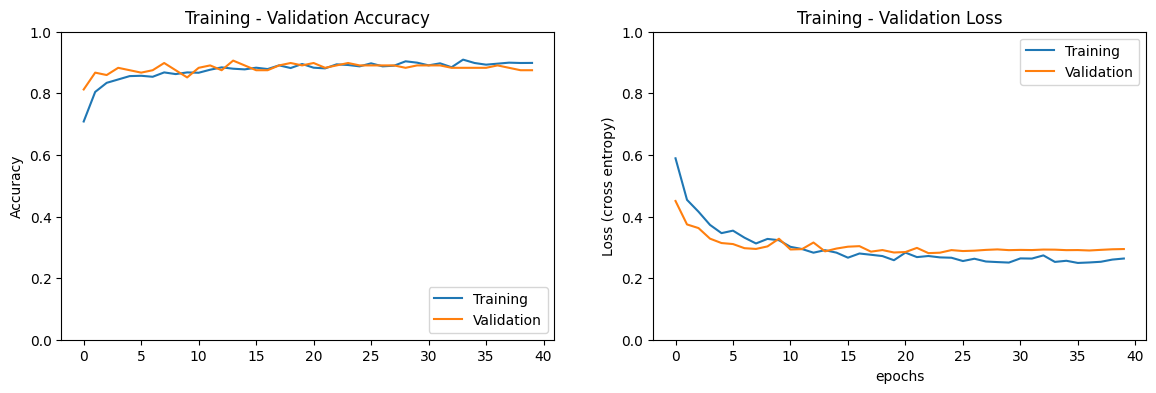

In [ ]:
plot_history(history, loss_max=1)

In [ ]:
# Generator for test dataset
datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input
        # rescale=1./255)
)
eval_datagen = datagen.flow(
        Xtest, ytest,
        batch_size=batch_size,
        shuffle=False)      # since shuffle was already during splitting into train, valid, test
# Evaluation on the test dataset
loss, acc = model.evaluate_generator(eval_datagen, verbose=0)
print(f'Test loss: {loss:.2f}')
print(f'Test accuracy: {acc*100:.2f}%')

<ipython-input-30-88ddd8ddaac0>:11: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  loss, acc = model.evaluate_generator(eval_datagen, verbose=0)


Test loss: 0.33
Test accuracy: 86.08%


In [ ]:
base_model.trainable = True

In [ ]:
print(f'Number of layers in the base model: {len(base_model.layers)}')

Number of layers in the base model: 154


In [ ]:
# Fine-tune from this layer onwards
fine_tuning = 100

# Freeze all the layers before fine_tuned_ind
for layer in base_model.layers[:fine_tuning]:
    layer.trainable =  False

In [ ]:
# Load best weights
# model.load_weights("/content/drive/MyDrive/cancer_best_weights.hdf5")

# Finer learning rate now
opt = tf.keras.optimizers.legacy.RMSprop(lr=0.0001, rho=0.9, epsilon=1e-08, decay=0.0)
    
# Compilation
model.compile(optimizer=opt, 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 2,260,546
Trainable params: 1,864,002
Non-trainable params: 396,544
_________________________________________________________________


In [ ]:
fine_tuned_epochs = 40
total_epochs = epochs_0 + fine_tuned_epochs

history_fined = model.fit_generator(
    train_gen,
    steps_per_epoch=len(Xtrain) // batch_size,   # or batch_size=32
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],
    validation_data=valid_gen,
    validation_steps=len(Xval) // batch_size,
    callbacks=callbacks)

<ipython-input-40-dc2a94155585>:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_fined = model.fit_generator(


Epoch 40/80
29/29 [==============================] - ETA: 0s - loss: 0.3562 - accuracy: 0.8450
Epoch 40: val_accuracy improved from 0.90625 to 0.92188, saving model to flower_best_weights.hdf5
29/29 [==============================] - 20s 434ms/step - loss: 0.3562 - accuracy: 0.8450 - val_loss: 0.3060 - val_accuracy: 0.9219 - lr: 1.0000e-04
Epoch 41/80
29/29 [==============================] - ETA: 0s - loss: 0.2139 - accuracy: 0.9181
Epoch 41: val_accuracy did not improve from 0.92188
29/29 [==============================] - 16s 555ms/step - loss: 0.2139 - accuracy: 0.9181 - val_loss: 0.3779 - val_accuracy: 0.8984 - lr: 1.0000e-04
Epoch 42/80
29/29 [==============================] - ETA: 0s - loss: 0.1686 - accuracy: 0.9367
Epoch 42: val_accuracy improved from 0.92188 to 0.94531, saving model to flower_best_weights.hdf5
29/29 [==============================] - 12s 411ms/step - loss: 0.1686 - accuracy: 0.9367 - val_loss: 0.2381 - val_accuracy: 0.9453 - lr: 1.0000e-04
Epoch 43/80
29/29 [=

In [ ]:
model.save("/content/drive/MyDrive/Dataset_oral/mobilenet.h5")

In [ ]:

def plot_history_fined(history, history_fined, initial_epochs=epochs_0, loss_max=1):
    """
    Check loss and accuracy evolution after fine tuning
    """
    
    acc = history.history['accuracy'][:epochs_0]
    acc += history_fined.history['accuracy']
    val_acc = history.history['val_accuracy'][:epochs_0]
    val_acc += history_fined.history['val_accuracy']
    loss = history.history['loss'][:epochs_0]
    loss += history_fined.history['loss']
    val_loss = history.history['val_loss'][:epochs_0]
    val_loss += history_fined.history['val_loss']
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(14, 4))
    ax1.plot(acc, label='Training')
    ax1.plot(val_acc, label='Validation')
    ax1.plot([initial_epochs-1,initial_epochs-1],
              plt.ylim(), label='fine-tuning', ls='--')
    ax1.legend(loc='lower right')
    ax1.set(ylabel='Accuracy', title='Training - Validation Accuracy', 
            ylim=([0.4,1.005]))
    ax2.plot(loss, label='Training')
    ax2.plot(val_loss, label='Validation')
    ax2.plot([initial_epochs-1,initial_epochs-1],
             [0,1] , label='fine-tuning', ls='--')
    ax2.legend(loc='upper right')
    ax2.set(ylabel='Loss (cross entropy)', xlabel='epochs',
           title='Training - Validation Loss', ylim=([0, loss_max]))
    plt.show()

In [ ]:
predictions = model.predict_generator(eval_datagen)

<ipython-input-56-4a961ba2f226>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(eval_datagen)


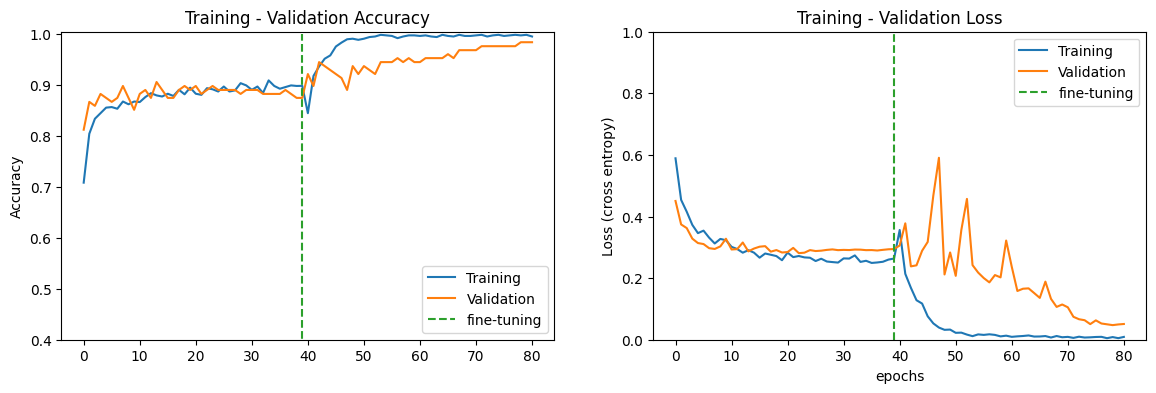

In [ ]:
plot_history_fined(history, history_fined)

In [ ]:
# Evaluation on the test dataset
loss, acc = model.evaluate_generator(eval_datagen, verbose=0)
print(f'Test loss: {loss:.2f}')
print(f'Test accuracy: {acc*100:.2f}%')

<ipython-input-48-90fc89cd4c64>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  loss, acc = model.evaluate_generator(eval_datagen, verbose=0)


Test loss: 0.30
Test accuracy: 93.04%


In [ ]:
y_pred = np.argmax(predictions,axis=1)
y_pred.shape

In [ ]:
y_test = eval_datagen.classes
Y_test=[]
for i in yval:
  for j in i:
    if (j==0):
      j=0
    else:
      j=1
    Y_test.append(j)
    break
print(Y_test)  

In [ ]:
report = classification_report(Y_test,y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.60      0.48      0.53        89
           1       0.47      0.58      0.52        69

    accuracy                           0.53       158
   macro avg       0.53      0.53      0.53       158
weighted avg       0.54      0.53      0.53       158



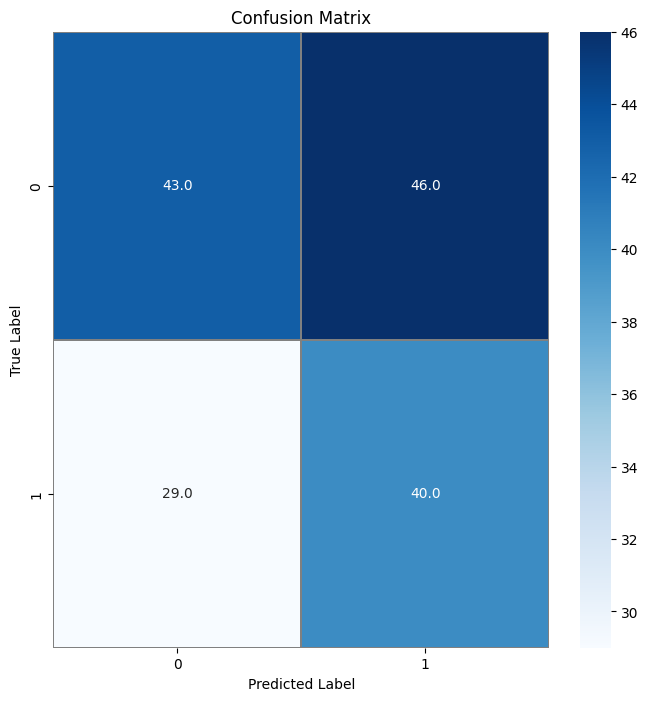

In [ ]:
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_test, y_pred) 
# plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Blues",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
predictions = model.predict(Xtest)

5/5 [==============================] - 0s 49ms/step


In [ ]:
# Get the index of the maximum value for each prediction array
y_pred_classes = np.argmax(predictions, axis=1)

# Print out the predicted class labels
print("Predicted class labels: ", y_pred_classes)

Predicted class labels:  [1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1
 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 0 0 1
 1 1 1 1 1 1 1 1 1 1]


In [ ]:
ytest

array([[0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.

In [ ]:
print(len(Xtrain))
print(len(ytrain))
print(len(Xval))
print(len(yval))

948
948
158
158


In [ ]:
yval[1]

array([0., 1.], dtype=float32)

In [ ]:
#Inorder to convert yval to array of numbers 
Y_test=[]
for i in yval:
  for j in i:
    if (j==0):
      j=0
    else:
      j=1
    Y_test.append(j)
    break
print(Y_test)  

[1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0]


In [ ]:
#checking whether values are correct

print(yval[140])
print(Y_test[140])
print(yval[2])
print(Y_test[2])

[0. 1.]
0
[1. 0.]
1


In [ ]:
#Inorder to convert ytrain to array of numbers 

Y_train=[]


for i in ytrain:
  for j in i:
    if (j==0):
      j=0
    else:
      j=1
    Y_train.append(j)
    break
print(Y_train)  

[0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 

In [ ]:
#checking whether values are correct

print(ytrain[152])
print(Y_train[152])
print(ytrain[69])
print(Y_train[69])

[0. 1.]
0
[1. 0.]
1


In [ ]:
# class label list
class_names = ['normal','oscc']
# example image for each classmobilenet_v2
images_dict = dict()
for i, l in enumerate(Y_train):
  if len(images_dict)==2:
    break
  if l not in images_dict.keys():
    images_dict[l] = Xtrain[i].reshape((224, 224,3))
images_dict = dict(sorted(images_dict.items()))

In [ ]:
# example image for each class for test set
Xval_dict = dict()
for i, l in enumerate(Y_test):
  if len(Xval_dict)==2:
    break
  if l not in Xval_dict.keys():
    Xval_dict[l] = Xval[i]

In [ ]:
# order by class
X_test_each_class = [Xval_dict[i] for i in sorted(Xval_dict)]
X_test_each_class = np.asarray(X_test_each_class)

In [ ]:
# Compute predictions
predictions = model.predict(X_test_each_class)
predicted_class = np.argmax(predictions, axis=1)

1/1 [==============================] - 1s 552ms/step


In [ ]:
Xtest_each_class = X_test_each_class/np.max(X_test_each_class)

In [ ]:
!pip install lime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 15.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283859 sha256=34f97d64ed9ca24becf365cddecece37a9c1c7c11488cc13130a7bc9b65a4594
  Stored in directory: /root/.cache/pip/wheels/ed/d7/c9/5a0130d06d6310bc6cbe55220e6e72dcb8c4eff9a478717066
Successfully built lime


In [ ]:
from lime import lime_image

explainer = lime_image.LimeImageExplainer()

In [ ]:
explanation = explainer.explain_instance(Xtest_each_class[1].astype('double'), model.predict,  
                                         top_labels=2, hide_color=0, num_samples=500)

  0%|          | 0/500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


(-0.5, 223.5, 223.5, -0.5)

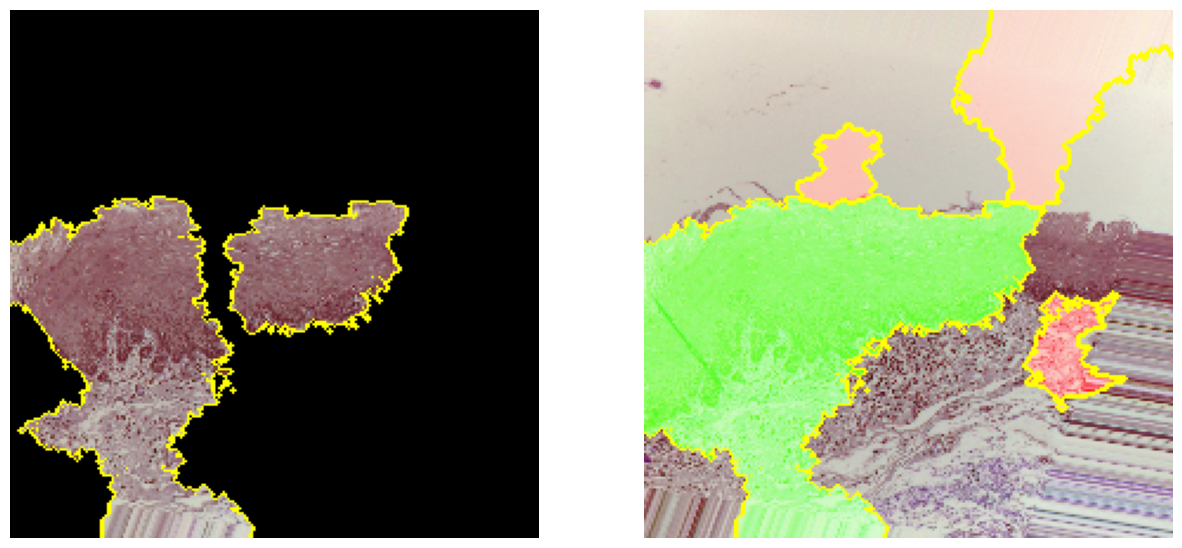

In [ ]:
from skimage.segmentation import mark_boundaries

temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
ax1.imshow(mark_boundaries(temp_1, mask_1))
ax2.imshow(mark_boundaries(temp_2, mask_2))
ax1.axis('off')
ax2.axis('off')

In [ ]:
print(keras.__version__)

NameError: ignored